In [2]:
from glob import glob
from xml.etree import ElementTree as ET
from matplotlib import pyplot as plt
from fastai.vision import *
from utils import *
from detection_network import *

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
xml_list = sorted(glob('DLAssignment/*.xml'))
img_list = sorted(glob('DLAssignment/*.jpg'))

In [5]:
img_list[10], xml_list[10]

('DLAssignment/14.jpg', 'DLAssignment/14.xml')

In [6]:
def get_parsed_bbox(pvoc_file):
    tree = ET.parse(pvoc_file)
    root = tree.getroot()
    bbox_list, categories = [], []
    for obj in root.iter('object'):
        rotated = int(obj.find("rotated").text) == 1
        box = obj.findall("bndbox")[0]
        xmin = int(box.find("xmin").text)
        ymin = int(box.find("ymin").text)
        xmax = int(box.find("xmax").text)
        ymax = int(box.find("ymax").text)
        an_obj_bbox = [ymin, xmin, ymax, xmax]
        bbox_list.append(an_obj_bbox)
        name = obj.find('name').text
#         lbl, ctgry = name.split('_')
#         if rotated: name = name+"_rtd"
        categories.append(name)
    return bbox_list, categories
        
def get_img_nd_lbl_bboxes(img_list, pvoc_list):
    imgs, lbl_bbox = [], []
    data_path_list = zip(img_list, pvoc_list)
    for img_path, pascal_voc_path in data_path_list:
        bbox_list, categories = get_parsed_bbox(pascal_voc_path)
        imgs.append(img_path)
        lbl_bbox.append([bbox_list,categories])
    return imgs, lbl_bbox

In [7]:
imgs, lbl_bbox = get_img_nd_lbl_bboxes(img_list, xml_list)

In [8]:
imgs = [img.split('/')[-1] for img in imgs]

In [9]:
img2bbox = dict(zip(imgs, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [10]:
path = Path('/home/ubuntu/bmk_work/nnets/')

In [11]:
#  Removing all the default agumentation transformations except zoom and lightning because 
#  we get similar images in the same orientation
tfms = get_transforms(do_flip = False, 
        flip_vert = False,
        max_rotate = 0,
        max_zoom = 1.15,
        max_lighting= 0.2,
        max_warp= 0,
        p_affine = 0.50,
        p_lighting = 0.30)

In [12]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(path/'imgs')
    src = src.split_by_rand_pct(valid_pct=0.15)
    src = src.label_from_func(get_y_func)
    src = src.transform(tfms, size=size, tfm_y=True)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)

In [13]:
bs=16
size=256
data = get_data(16,256)

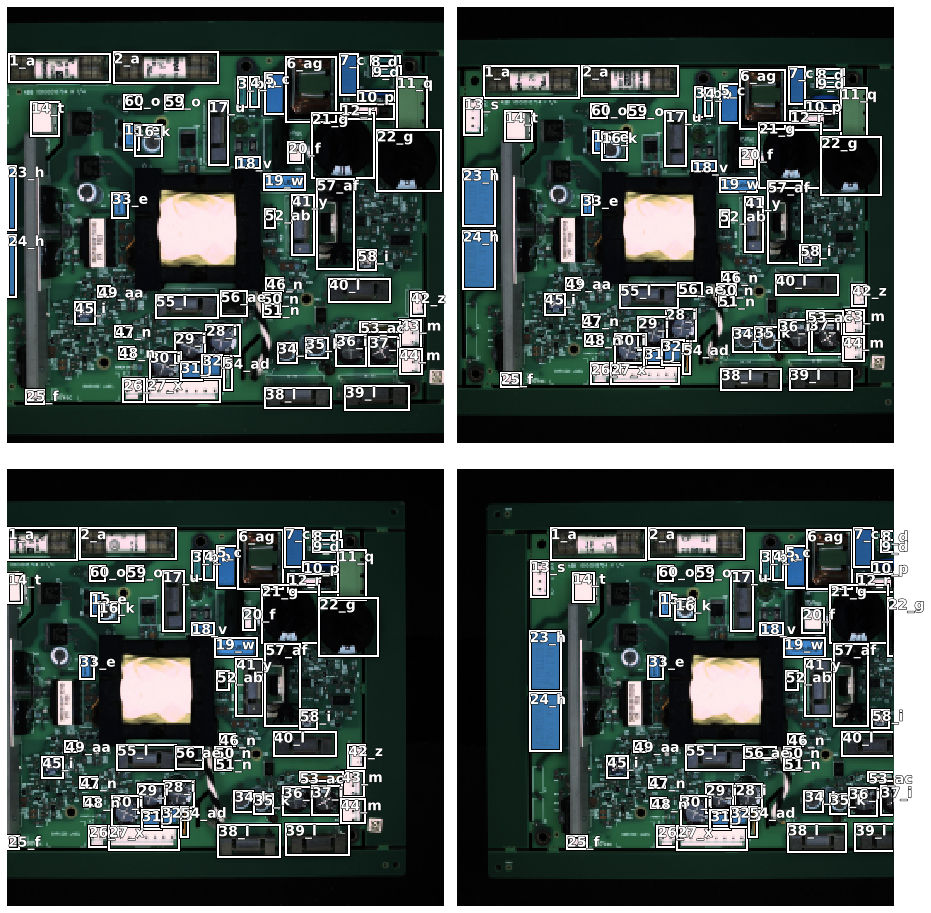

In [14]:
data.show_batch(rows=2,figsize=(13,13))

In [15]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]
#scales = [1,2**(1/3), 2**(2/3)] for bigger size

In [16]:
encoder = create_body(models.resnet50, cut=-2)
model = RetinaNet(encoder, data.c, final_bias=-4)
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)
learn = Learner(data, model, loss_func=crit)

In [17]:
def retina_net_split(model):
    groups = [list(model.encoder.children())[:6], list(model.encoder.children())[6:]]
    return groups + [list(model.children())[1:]]

In [18]:
learn = learn.split(retina_net_split)

In [19]:
learn.freeze()

In [20]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,3.625186,#na#,00:14
1,3.624053,#na#,00:11
2,3.618869,#na#,00:11
3,3.605381,#na#,00:11
4,3.551891,#na#,00:11
5,3.463518,#na#,00:11
6,3.289218,#na#,00:12
7,3.232670,#na#,00:12
8,3.328148,#na#,00:11


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-05
Min loss divided by 10: 6.92E-05


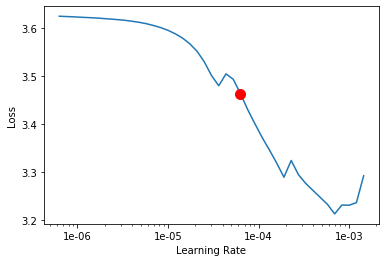

In [21]:
learn.recorder.plot(skip_end=5,suggestion=True)

In [22]:
learn.fit_one_cycle(5, 6e-5)

epoch,train_loss,valid_loss,time
0,3.584458,3.414233,00:19
1,3.347227,2.614957,00:18
2,3.051040,2.422587,00:18
3,2.895744,2.301061,00:18
4,2.749430,2.263144,00:18


In [23]:
learn.save('stage1_256_2')

In [24]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,time
0,2.277513,#na#,00:11
1,2.287391,#na#,00:11
2,2.295188,#na#,00:11
3,2.280951,#na#,00:11
4,2.235534,#na#,00:11
5,2.139494,#na#,00:12
6,2.018494,#na#,00:11
7,1.951909,#na#,00:11
8,2.060202,#na#,00:11
9,4.269673,#na#,00:12


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-04
Min loss divided by 10: 6.92E-05


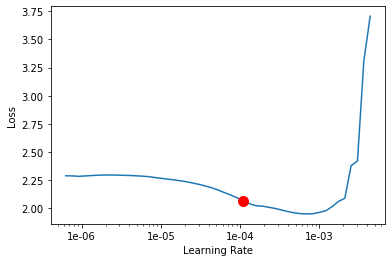

In [25]:
learn.recorder.plot(suggestion=True)

In [26]:
learn.fit_one_cycle(20, slice(1e-5, 4e-4))

epoch,train_loss,valid_loss,time
0,2.245196,2.139816,00:18
1,2.097957,1.823699,00:18
2,1.938898,1.506539,00:19
3,1.779676,1.237032,00:19
4,1.621757,1.074232,00:18
5,1.495606,0.986039,00:18
6,1.378312,0.793612,00:18
7,1.252551,0.620461,00:19
8,1.133402,0.471610,00:18
9,1.021298,0.422260,00:19


In [27]:
learn.save('stage2_256_2')

In [20]:
learn = learn.load('stage2_256')

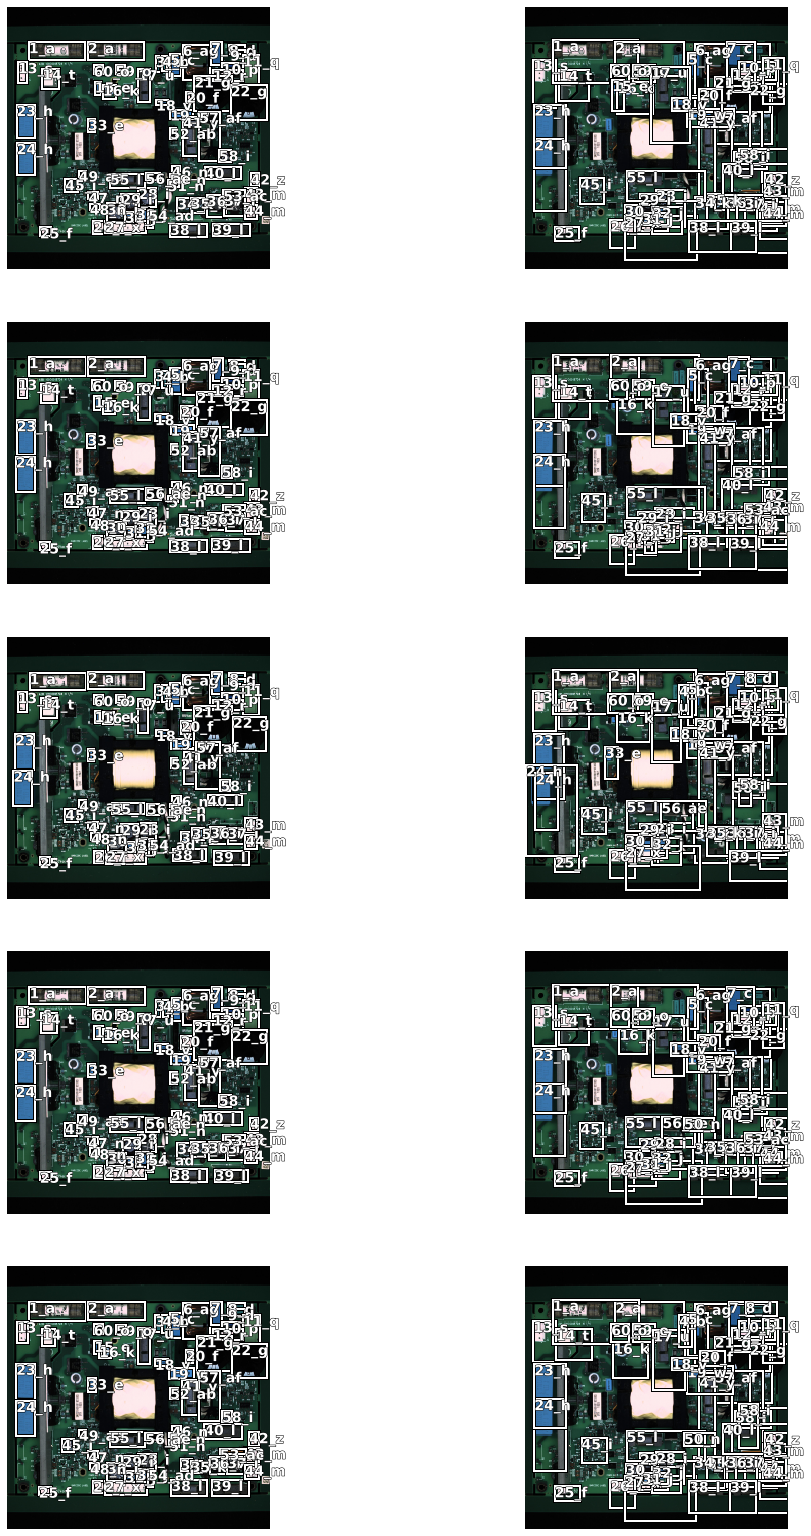

In [37]:
show_results(learn, start=8, detect_thresh=0.65,figsize=(17, 28))

In [22]:
L = compute_class_AP(learn.model, data.valid_dl, data.c-1)

In [23]:
aps = []
for ap,cl in zip(L, data.classes[1:]): 
    aps.append(ap)

In [25]:
import seaborn as sns

In [30]:
mAP_df = pd.DataFrame([data.classes[1:],L]).T

In [31]:
mAP_df.columns = ['classes', 'AP']

In [38]:
mAP_df.sort_values(by='AP',ascending=False,inplace=True)

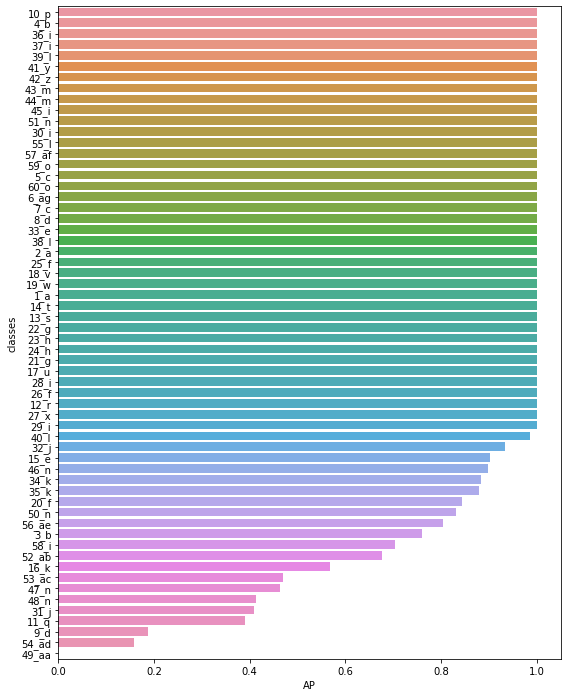

In [48]:
fig, ax = plt.subplots(figsize=(9,12))
sns.barplot(mAP_df.AP, mAP_df.classes,ax=ax)
plt.show()

In [49]:
mAP = np.mean(aps)

In [50]:
print(mAP)

0.8693413526221282
